# Lista 8
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)
___
## Importy

In [23]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

___
## Zadanie 1

Liczba recenzji (w użyciu): 5000

Rozkład klas (0 = negatywna, 1 = pozytywna):
label
1    2504
0    2496
Name: count, dtype: int64

Średnia długość tekstu: 1319.58 znaków

Statystyki długości recenzji (w słowach):
count    5000.000000
mean      233.074800
std       174.758653
min        10.000000
25%       127.000000
50%       177.000000
75%       285.000000
max      2125.000000
Name: len_tokens, dtype: float64

Przykładowa recenzja:
                                                text  label
0  Forget what I said about Emeril. Rachael Ray i...      0


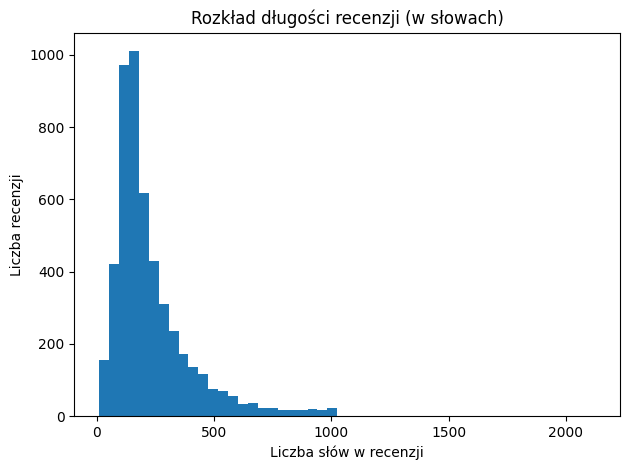

In [24]:
dataset = load_dataset("imdb")

df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])
df = pd.concat([df_train, df_test], ignore_index=True)

df = df.sample(5000, random_state=42).reset_index(drop=True)

print(f"Liczba recenzji (w użyciu): {len(df)}")

print("\nRozkład klas (0 = negatywna, 1 = pozytywna):")
print(df["label"].value_counts())

df["len_chars"] = df["text"].str.len()
print(f"\nŚrednia długość tekstu: {df['len_chars'].mean():.2f} znaków")

df["len_tokens"] = df["text"].str.split().str.len()
print("\nStatystyki długości recenzji (w słowach):")
print(df["len_tokens"].describe())

print("\nPrzykładowa recenzja:")
print(df[["text", "label"]].head(1))

plt.figure()
plt.hist(df["len_tokens"], bins=50)
plt.xlabel("Liczba słów w recenzji")
plt.ylabel("Liczba recenzji")
plt.title("Rozkład długości recenzji (w słowach)")
plt.tight_layout()
plt.show()

___
## Zadanie 2

In [25]:
STOPWORDS = set(ENGLISH_STOP_WORDS) - {"not", "no"}

def clean_text(text: str) -> str:
    text = text.lower()
    
    # HTML z IMDB
    text = re.sub(r"<br\s*/?>", " ", text)
    
    # usunięcie cyfr, interpunkcji itd.
    text = re.sub(r"[^a-z\s]", " ", text)
    
    words = text.split()
    words = [w for w in words if w not in STOPWORDS]
    
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

print(f"Przed: {df['text'][0]}")
print(f"Po:    {df['clean_text'][0]}\n")

Przed: Forget what I said about Emeril. Rachael Ray is the most irritating personality on the Food Network AND all of television. If you've never seen 30 Minute Meals, then you cannot possibly begin to comprehend how unfathomably annoying she is. I really truly meant that you can't even begin to be boggled by her until you've viewed the show once or twice, and even then all words and intelligent thoughts will fail you. The problem is mostly with her mannerisms as you might have guessed. Ray has a goofy mouth and often imitates the parrot. If you love something or think it's "awesome" (a word she uses roughly 87 times per telecast) just say it. And she's constantly using horrible, unfunny catchphrases like "EVOO" (Extra virgin olive oil!). SHUT UP! What's worse is Ray has TWO other shows on the network! I think this is some elaborate conspiracy by the terrorists to drive us mad. Give me more Tyler Florence! Ray is lame.
Po:    forget said emeril rachael ray irritating personality food n

___
## Zadanie 3

In [ ]:
X_text = df["clean_text"].values
y = df["label"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

vectorizer = TfidfVectorizer(
    max_features=20000,   # maksymalnie 20k najczęstszych słów
    min_df=5,             # słowo musi wystąpić w >= 5 dokumentach
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print(f"Kształt macierzy cech (train): {X_train.shape} (recenzje x słowa)")
print(f"Kształt macierzy cech (test):  {X_test.shape} (recenzje x słowa)")

Kształt macierzy cech (train): (4000, 9299) (recenzje x słowa)
Kształt macierzy cech (test):  (1000, 9299) (recenzje x słowa)


___
## Zadanie 4

In [27]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

print("Model został wytrenowany.")

Model został wytrenowany.


___
## Zadanie 5

Dokładność (accuracy): 0.8610

Raport klasyfikacji:
              precision    recall  f1-score   support

   negatywna       0.85      0.88      0.86       499
   pozytywna       0.88      0.84      0.86       501

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

Macierz pomyłek (wartości):
[[439  60]
 [ 79 422]]


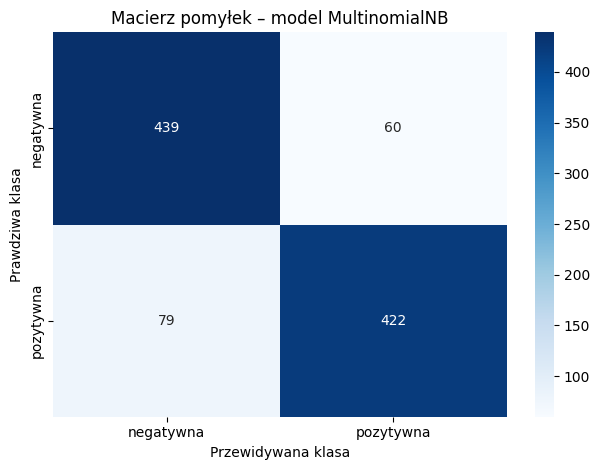

In [28]:
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Dokładność (accuracy): {acc:.4f}\n")

print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=["negatywna", "pozytywna"]))

cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek (wartości):")
print(cm)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["negatywna", "pozytywna"],
    yticklabels=["negatywna", "pozytywna"]
)
plt.xlabel("Przewidywana klasa")
plt.ylabel("Prawdziwa klasa")
plt.title("Macierz pomyłek – model MultinomialNB")
plt.tight_layout()
plt.show()

___
## Zadanie 6

In [ ]:
new_reviews = [
    "This movie was fantastic, I loved every minute of it!",   
    "Terrible film, complete waste of time and money.",       
    "It was okay, not great but not awful either."             
]

new_reviews_clean = [clean_text(r) for r in new_reviews]

X_new = vectorizer.transform(new_reviews_clean)

new_pred = clf.predict(X_new)

label_map = {0: "negatywna", 1: "pozytywna"}

for original, cleaned, pred in zip(new_reviews, new_reviews_clean, new_pred):
    print("\nOryginalna recenzja:")
    print(original)
    print("Po pre-processingu:")
    print(cleaned)
    print("Przewidywany wydźwięk:", label_map[pred])
    print("-" * 80)


Oryginalna recenzja:
This movie was fantastic, I loved every minute of it!
Po pre-processingu:
movie fantastic loved minute
Przewidywany wydźwięk: pozytywna
--------------------------------------------------------------------------------

Oryginalna recenzja:
Terrible film, complete waste of time and money.
Po pre-processingu:
terrible film complete waste time money
Przewidywany wydźwięk: negatywna
--------------------------------------------------------------------------------

Oryginalna recenzja:
It was okay, not great but not awful either.
Po pre-processingu:
okay not great not awful
Przewidywany wydźwięk: negatywna
--------------------------------------------------------------------------------
